In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torchvision
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
train_dataset = FashionMNIST(root='data/',download= True,train=True, transform=transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()])
)

In [3]:
test_dataset = FashionMNIST(root='data/',download= True,train=False, transform=transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()])
)

In [4]:
img_tensor, label = train_dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 9


In [5]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, drop_last=True,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32,drop_last=True, shuffle=True)

In [29]:
class AE(nn.Module):
    def __init__(self,input_features,output_features):
        super().__init__()
        self.encoder_hidden_layer_1 = nn.Linear(
            in_features=input_features, out_features=128
        )
        self.encoder_hidden_layer_2= nn.Linear(
            in_features=128, out_features=128
        )
        self.encoder_hidden_layer_3 = nn.Linear(
            in_features=128, out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer_1= nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer_2 = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer_3 = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=output_features
        )

    def encoder(self, x):
        activation = self.encoder_hidden_layer_1(x)
        activation = torch.relu(activation)
        activation = self.encoder_hidden_layer_2(activation)
        activation = torch.relu(activation)
        activation = self.encoder_hidden_layer_3(activation)
        activation = torch.relu_(activation)
        code = self.encoder_output_layer(activation)
        encoded = torch.relu(code)
        return encoded

    def decoder(self,x):
        activation = self.decoder_hidden_layer_1(x)
        activation = torch.relu(activation)
        activation = self.decoder_hidden_layer_2(activation)
        activation = torch.relu(activation)
        activation = self.decoder_hidden_layer_3(activation)
        activation = torch.relu_(activation)
        activation = self.decoder_output_layer(activation)
        decoded = torch.relu(activation)
        return decoded

    def forward(self, x):
      reconstructed= self.decoder(self.encoder(x))
      return reconstructed

In [30]:
device = torch.device ("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
  #create an instance of model and send it to the target device
model_0= AE(input_features=784,
                   output_features=784).to(device)


In [64]:
#create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.SGD(model_0.parameters(), lr=0.1)

# mean-squared error loss
loss_fn = nn.MSELoss()

In [ ]:
noisy_data = (batch_features + 0.50 * torch.randn(batch_features.shape).to(device))
noisy_data = noisy_data.view(-1, 784).to(device)

In [65]:
epochs=5
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dataloader:
        # reshaping the input matrix
        noisy_data = (batch_features + 0.01 * torch.randn(batch_features.shape).to(device))
        noisy_data = noisy_data.view(-1, 784).to(device)
        batch_features = batch_features.view(-1, 784).to(device)
        optimizer.zero_grad()
        outputs = model_0(noisy_data)
        
        # compute loss & update parameter
        # print(type(loss))
        train_loss = loss_fn(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_dataloader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/5, loss = 0.152079
epoch : 2/5, loss = 0.116340
epoch : 3/5, loss = 0.113364
epoch : 4/5, loss = 0.111189
epoch : 5/5, loss = 0.110120


#Model with 3fc layer classifier

In [66]:
from torch import nn
#building a multiclass classification model
class Clsf(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.linear_layer_stack= nn.Sequential(
        nn.Linear(in_features= input_features, out_features=hidden_units),
        nn.Sigmoid(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Sigmoid(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Sigmoid(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self,x):
    value=model_0.encoder(x)
    value=self.linear_layer_stack(value)
    return value

  #create an instance of model and send it to the target device
model_1= Clsf(input_features=128,
                   output_features=10,
                   hidden_units=100).to(device)



In [67]:
#create a loss function and an optimizer for multi-class classification model
loss_fn= nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)


In [68]:
#Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc= (correct/len(y_pred))*100
  return acc

In [69]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set number of epochs
epochs=10

#data to target device

#loop through data
for epoch in range(epochs):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y =X.to(device), y.to(device)


    #training
    model_1.train()

    #1. forward pass
    y_logits = model_1(X.view(-1,784))

    #2.Calculate the loss/acc
    loss = loss_fn(y_logits, y)

    train_loss = train_loss + loss
    
    #3.Optimizer zero grad
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. optimizer step(gradient descent)
    optimizer.step()

  
  ##Testing
  model_1.eval()

  with torch.inference_mode():
    test_loss = 0
    for X, y in test_dataloader:
      X, y=X.to(device), y.to(device)
    #1. forward pass
      test_logits = model_1(X.view(-1,784))
      # test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

      #2. calculte the loss
      test_loss = test_loss + loss_fn(test_logits, y)
    
  #print out whats hapening
  train_loss = train_loss / len(train_dataloader)
  test_loss = test_loss / len(test_dataloader)
  #if epoch ==0:
  print(f"Epoch: {epoch} | train loss:{train_loss:.5f} | Test loss:{test_loss:.5f}   ")




Epoch: 0 | train loss:2.31577 | Test loss:2.30185   
Epoch: 1 | train loss:2.19271 | Test loss:1.96583   
Epoch: 2 | train loss:1.95481 | Test loss:1.92413   
Epoch: 3 | train loss:1.90981 | Test loss:1.88291   
Epoch: 4 | train loss:1.88181 | Test loss:1.87171   
Epoch: 5 | train loss:1.87252 | Test loss:1.87703   
Epoch: 6 | train loss:1.86517 | Test loss:1.85634   
Epoch: 7 | train loss:1.85817 | Test loss:1.85585   
Epoch: 8 | train loss:1.84910 | Test loss:1.83818   
Epoch: 9 | train loss:1.83632 | Test loss:1.82978   


#model with 1 fc layer

In [70]:
from torch import nn
#building a multiclass classification model
class Clsf_1(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.linear_layer_1= nn.Sequential(
        nn.Linear(in_features= input_features, out_features=hidden_units),
        nn.Sigmoid(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self,x):
    value=model_0.encoder(x)
    value=self.linear_layer_1(value)
    return value

  #create an instance of model and send it to the target device
model_2= Clsf_1(input_features=128,
                   output_features=10,
                   hidden_units=100).to(device)



In [71]:
#create a loss function and an optimizer for multi-class classification model
loss_fn= nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)


In [72]:
#Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc= (correct/len(y_pred))*100
  return acc

In [73]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set number of epochs
epochs=10

#data to target device

#loop through data
for epoch in range(epochs):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y =X.to(device), y.to(device)


    #training
    model_2.train()

    #1. forward pass
    y_logits = model_2(X.view(-1,784))

    #2.Calculate the loss/acc
    loss = loss_fn(y_logits, y)

    train_loss = train_loss + loss
    
    #3.Optimizer zero grad
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. optimizer step(gradient descent)
    optimizer.step()

  
  ##Testing
  model_2.eval()

  with torch.inference_mode():
    test_loss = 0
    for X, y in test_dataloader:
      X, y=X.to(device), y.to(device)
    #1. forward pass
      test_logits = model_2(X.view(-1,784))
      # test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

      #2. calculte the loss
      test_loss = test_loss + loss_fn(test_logits, y)
    
  #print out whats hapening
  train_loss = train_loss / len(train_dataloader)
  test_loss = test_loss / len(test_dataloader)
  #if epoch ==0:
  print(f"Epoch: {epoch} | train loss:{train_loss:.5f} | Test loss:{test_loss:.5f}   ")




Epoch: 0 | train loss:1.99581 | Test loss:1.93446   
Epoch: 1 | train loss:1.93878 | Test loss:1.91719   
Epoch: 2 | train loss:1.90792 | Test loss:1.88702   
Epoch: 3 | train loss:1.87401 | Test loss:1.84981   
Epoch: 4 | train loss:1.82876 | Test loss:1.79495   
Epoch: 5 | train loss:1.75882 | Test loss:1.71671   
Epoch: 6 | train loss:1.66375 | Test loss:1.60629   
Epoch: 7 | train loss:1.56928 | Test loss:1.53965   
Epoch: 8 | train loss:1.49195 | Test loss:1.44893   
Epoch: 9 | train loss:1.43133 | Test loss:1.37973   


#TSNE With Autoencoder

In [74]:
lt_embed = []
lt_lb = []
ln = 0 
with torch.no_grad():
  for img, lb in test_dataloader:
    embed = model_0.encoder(img.to(device).view(-1, 784))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break
embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb)

In [75]:
from sklearn.manifold import TSNE

In [76]:
tsne = TSNE(n_components=2, random_state=0)

tsne_data = tsne.fit_transform(embed_tensor)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


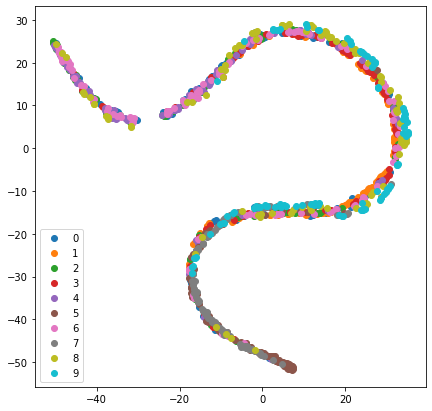

In [77]:
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()

#TSNE with 3-Fc layer

In [78]:
lt_embed = []
lt_lb = []
ln = 0 
with torch.no_grad():
  for img, lb in test_dataloader:
    embed = model_1(img.to(device).view(-1, 784))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break
embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb)

In [79]:
tsne = TSNE(n_components=2, random_state=0)

tsne_data = tsne.fit_transform(embed_tensor)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


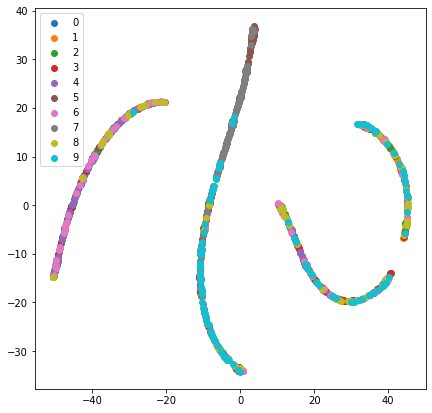

In [80]:
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()

#TSNE with 1FC layer

In [81]:
lt_embed = []
lt_lb = []
ln = 0 
with torch.no_grad():
  for img, lb in test_dataloader:
    embed = model_2(img.to(device).view(-1, 784))
    lt_embed.append(embed.cpu())
    lt_lb.append(lb)
    ln+=len(img)
    if(ln>=1000):
      break
embed_tensor = torch.cat(lt_embed)
label_tensor = torch.cat(lt_lb)

In [82]:
tsne = TSNE(n_components=2, random_state=0)

tsne_data = tsne.fit_transform(embed_tensor)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


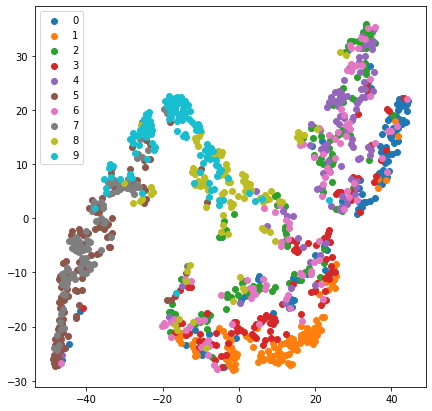

In [83]:
scatter_x = tsne_data[:,0]
scatter_y = tsne_data[:,1]
group = label_tensor

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.show()